In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image

# NeRF

In [2]:
class NerfModel(nn.Module):
	def __init__(self, hidden = 256, oL = 10, dL = 4, device = 'cuda'):
		super(NerfModel, self).__init__()
		self.oL = oL
		self.dL = dL
		self.relu = nn.functional.relu
		self.device = device
		
		# encoding position
		self.sequence1 = nn.Sequential(
			nn.Linear(6*oL + 3, hidden), nn.ReLU(),
			nn.Linear(hidden, hidden), nn.ReLU(),
			nn.Linear(hidden, hidden), nn.ReLU(),	# reduced
			nn.Linear(hidden, hidden), nn.ReLU(),	# reduced
			nn.Linear(hidden, hidden), nn.ReLU()	# original
		).to(device)
		
		# decoding density + encoding position
		self.sequence2 = nn.Sequential(
			nn.Linear(hidden + 6*oL + 3, hidden), nn.ReLU(),
			nn.Linear(hidden, hidden), nn.ReLU(),	# reduced
			nn.Linear(hidden, hidden), nn.ReLU(),	# reduced
			nn.Linear(hidden, hidden + 1)
		).to(device)
		
		# encoding color
		self.sequence3 = nn.Sequential(
			nn.Linear(hidden + 6*dL + 3, hidden//2), nn.ReLU(),
			nn.Linear(hidden//2, 3), nn.Sigmoid()
		).to(device)
	
	
	
	def forward(self, o, d):
		gammaO = NerfModel.computeGamma(o, self.oL)
		gammaD = NerfModel.computeGamma(d, self.dL)
		
		# encoding position
		encodedO1 = self.sequence1(gammaO)
		
		# decoding density + encoding position
		gammaO_encodedO1 = torch.cat((gammaO, encodedO1), dim = 1)
		sigma_encodedO2 = self.sequence2(gammaO_encodedO1)
		sigma, encodedO2 = self.relu(sigma_encodedO2[:, 0]), sigma_encodedO2[:, 1:]
		
		# encoding color
		gammaD_encodedO2 = torch.cat((gammaD, encodedO2), dim = 1)
		c = self.sequence3(gammaD_encodedO2)
		
		return c, sigma
	
	
	
	@staticmethod
	def computeGamma(x, l):
		encodedPosition = [x]
		powerOf2Pi = 3.14
		for i in range(l):
			encodedX = powerOf2Pi*x
			encodedPosition.append(torch.sin(encodedX))
			encodedPosition.append(torch.cos(encodedX))
			powerOf2Pi *= 2
		return torch.cat(encodedPosition, dim = 1)
	
	
	
	@staticmethod
	def computeCHat(model, o, d, tn = 0.0, tf = 1.0, N = 64):
		S = o.shape[0]
		
		# Generating t_i
		# t: S x N
		shape = (S, N)
		r = torch.rand(shape, device = model.device)
		step = (tf - tn)/N
		t = torch.linspace(tn, tf - step, N, device = model.device).expand(shape) + step*r
		
		# Generating delta_i, where the last is 1
		# delta: S x N
		ones = torch.ones((S, 1), device = model.device)
		delta = torch.cat((
			t[:, 1:] - t[:, :-1],
			1e9*ones
		), 1)
		
		# Computing c_i and sigma_i
		# o: S x 3
		# d: S x 3
		# t: S x N
		#
		# o': S x N x 3
		# d': S x N x 3
		#
		# c: S x N x 3
		# sigma: S x N
		oPrime = o.unsqueeze(1) + t.unsqueeze(2)*d.unsqueeze(1)	# oPrime(ijk) = o(ik) + t(ij)*d(ik)
		dPrime = d.unsqueeze(1).expand(S, N, 3)
		
		c, sigma = model(oPrime.reshape(-1, 3), dPrime.reshape(-1, 3))
		c = c.reshape(S, N, 3)
		sigma = sigma.reshape(S, N)
		
		# Computing alpha_i T_i, w_i and cHat
		# alpha: S x N
		# T: S x N
		# w: S x N
		# cHat: S x 3
		#
		# Ci = (1 - ai)*Ci+1 + ai*ci
		# C1 = (1 - a1)*...*(1 - an)Cn+1 + (1 - a1)*...*(1 - an-1)ancn + ... + a1c1
		# C1 = Tn(1 - an)Cn+1 + SUM(Ti*ai*ci, 1 <= i <= n)
		# C1 = (Tn - wn)Cn+1 + SUM(wi*ai, 1 <= i <= n)
		alpha = 1 - torch.exp(-sigma*delta)
		T = torch.cumprod(1 - alpha, 1)
		T = torch.cat((ones, T[:, :-1]), dim = 1)
		w = T*alpha
		cHat = (T[:, -1] - w[:, -1]).unsqueeze(1) + (w.unsqueeze(2)*c).sum(dim = 1)	# Cn+1 = white
		
		return cHat
	
	
	
	@staticmethod
	def doTraining(model, optimizer, scheduler, dataLoader, epochs = 16, tn = 0.0, tf = 10.0, N = 192, maxBatches = 10000):
		model.train()
		lossList = []
		
		for e in range(epochs):
			print(f'epoch: {e + 1} of {epochs}')

			length = min(maxBatches, len(dataLoader))
			it = iter(dataLoader)
			for _ in tqdm(range(length)):
				o, d, C = next(it)
				o, d, C = o.to(model.device), d.to(model.device), C.to(model.device)
				
				# Computing loss
				cHat = NerfModel.computeCHat(model, o, d, tn = tn, tf = tf, N = N)
				loss = ((cHat - C)**2).sum()
				
				# Backpropagation
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()
				lossList.append(loss.item())
			
			# Decaying learning rate
			scheduler.step()
		
		model.eval()
		return lossList
	
	
	
	@staticmethod
	@torch.no_grad()
	def render(model, pos, eye, up, tn = 0.0, tf = 1.0, N = 192, imageWidth = 400, imageHeight = 400, chunkSize = 1024, fov = 75):
		# Generating the view matrix
		normalize = lambda x : torch.nn.functional.normalize(x, dim = 0)
		cross = lambda x, y : torch.cross(x, y, dim = 0)
		dot = lambda x, y : torch.dot(x, y).unsqueeze(0)
		
		z = normalize(eye - pos)
		x = normalize(cross(up, z))
		y = normalize(cross(z, x))
		
		# local*mat = global
		mat = torch.stack([x, y, z])
		
		# Generating rays
		tangent = 3.14/360.0
		tangent *= fov
		tangent = np.tan(tangent)
		ratio = imageWidth/imageHeight
		
		px = tangent*torch.linspace(-ratio, ratio, imageWidth)
		py = tangent*torch.linspace(-1.0, 1.0, imageHeight)
		numPx = imageWidth*imageHeight
		d = torch.zeros((numPx, 3))
				
		for j in range(imageHeight):
			for i in range(imageWidth):
				k = i + j*imageWidth
				d[k, 0] = px[i]
				d[k, 1] = py[j]
				d[k, 2] = -1.0
		
		d = torch.matmul(d, mat)
		d = torch.nn.functional.normalize(d, dim = 1)
		o = eye.repeat(imageWidth*imageHeight, 1)
		
		# Rendering each ray in chunks
		chunks = []
		numChunk = int(np.ceil(numPx/chunkSize))
		with torch.no_grad():
			for c in tqdm(range(numChunk)):
				oChunk = o[c*chunkSize:(c + 1)*chunkSize].to(model.device)
				dChunk = d[c*chunkSize:(c + 1)*chunkSize].to(model.device)
				cHat = NerfModel.computeCHat(model, oChunk, dChunk, tn = tn, tf = tf, N = N)
				chunks.append(cHat.to('cpu'))

		return torch.cat(chunks).reshape(imageHeight, imageWidth, 3)
		

## Training model

### Load data

In [4]:
device = 'cuda'
torch.cuda.empty_cache()


data = np.load('data/training_data.pkl', allow_pickle = True)
trainTensor = torch.from_numpy(data)#.to(device)
trainTensorDataset = TensorDataset(trainTensor[:, :3], trainTensor[:, 3:6], trainTensor[:, 6:])

### Generate batches

In [5]:
trainDataLoader = DataLoader(trainTensorDataset, batch_size = 2**10, shuffle = True)

### Generate the NeRF model, the ADAM optimizer, and the Multi Step Learning Rate Scheduler

In [16]:
model = NerfModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4, eps = 1e-7)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [1, 2, 3], gamma = 0.5)

### Train

epoch: 1 of 4


100%|██████████| 15625/15625 [13:22<00:00, 19.46it/s]


epoch: 2 of 4


100%|██████████| 15625/15625 [13:19<00:00, 19.55it/s]


epoch: 3 of 4


100%|██████████| 15625/15625 [12:16<00:00, 21.23it/s]


epoch: 4 of 4


100%|██████████| 15625/15625 [12:15<00:00, 21.23it/s]


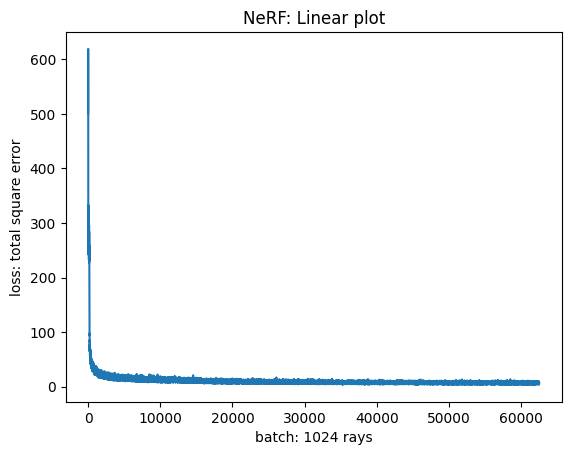

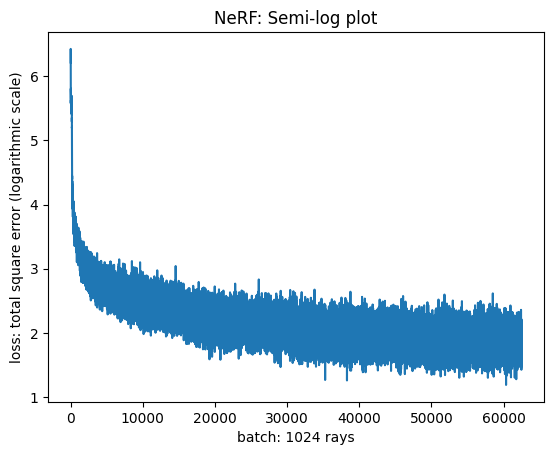

In [17]:
lossList = NerfModel.doTraining(model, optimizer, scheduler, trainDataLoader, epochs = 4, tn=0, tf=8, N=192, maxBatches = 10000000)

torch.save(model.state_dict(), "weights/nerfWeights2.w")
torch.save(optimizer.state_dict(), "optimizers/nerfOptimizer2.o")
torch.save(optimizer.state_dict(), "schedulers/nerfScheduler2.s")
torch.save(lossList, "loss/nerfLoss2.l")

#index = 0*int(len(lossList)/2)

#xs = [index + x for x in range(len(lossList) - index)]
#plt.plot(xs, lossList[index:])
#plt.title("NeRF: Linear plot")
#plt.xlabel("batch: 1024 rays")
#plt.ylabel("loss: total square error")
#plt.show()

#plt.plot(xs, [np.log(l) for l in lossList[index:]])
#plt.title("NeRF: Semi-log plot")
#plt.xlabel("batch: 1024 rays")
#plt.ylabel("loss: total square error (logarithmic scale)")
#plt.show()

## Loading model

### Load the NeRF model, the ADAM optimizer, and the Multi Step Learning Rate Scheduler

In [3]:
device = 'cuda'
torch.cuda.empty_cache()

model = NerfModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4, eps = 1e-7)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [1, 2, 3], gamma = 0.5)

model.load_state_dict(torch.load("weights/nerfWeights.w"))
optimizer.load_state_dict(torch.load("optimizers/nerfOptimizer.o"))
scheduler.load_state_dict(torch.load("schedulers/nerfScheduler.s"))
lossList = torch.load("loss/nerfLoss.l")

### Plot the loss in linear and semi-log graph

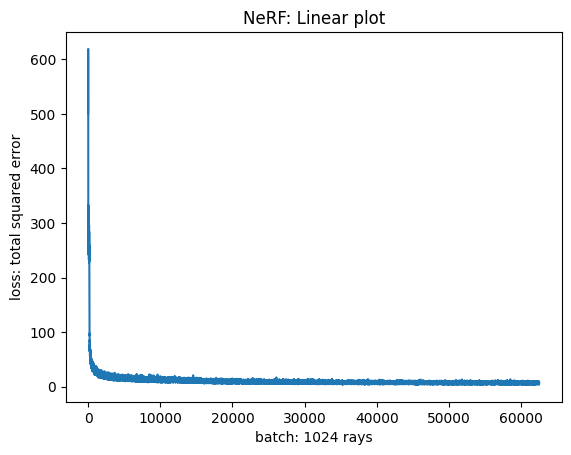

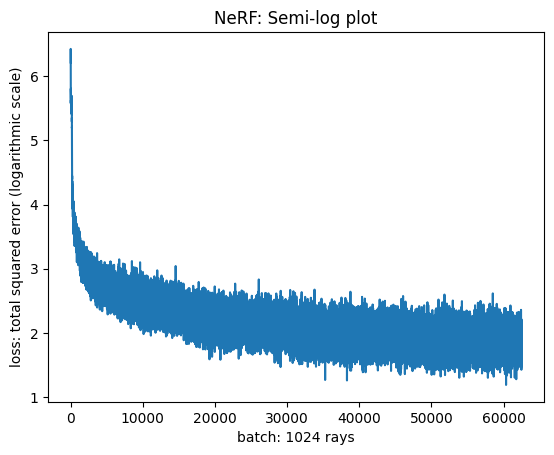

In [5]:
index = 0*int(len(lossList)/2)

xs = [index + x for x in range(len(lossList) - index)]
plt.plot(xs, lossList[index:])
plt.title("NeRF: Linear plot")
plt.xlabel("batch: 1024 rays")
plt.ylabel("loss: total squared error")
plt.show()

plt.plot(xs, [np.log(l) for l in lossList[index:]])
plt.title("NeRF: Semi-log plot")
plt.xlabel("batch: 1024 rays")
plt.ylabel("loss: total squared error (logarithmic scale)")
plt.show()

## Rendering

### Render a single image

In [4]:
pos = torch.tensor([0, 0,  0])
#eye = torch.tensor([2.1031, -1.0323,  3.2804])
eye = torch.tensor([1.0, 1.0, 0.2])
up = torch.tensor([0.0, 0.0, -1.0])


#eye[0] = 2.3427916894167095367449788579956*np.cos(90*(2*np.pi)/360)
#eye[1] = 2.3427916894167095367449788579956*np.sin(90*(2*np.pi)/360)
cHat = NerfModel.render(model, pos, eye, up, tn = 0.6, tf = 2.4, N = 192, imageWidth = 10*192, imageHeight = 10*108, chunkSize = 1024)
print(cHat.shape)

100%|██████████| 2025/2025 [02:40<00:00, 12.63it/s]

torch.Size([1080, 1920, 3])


### Plot the rendered image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


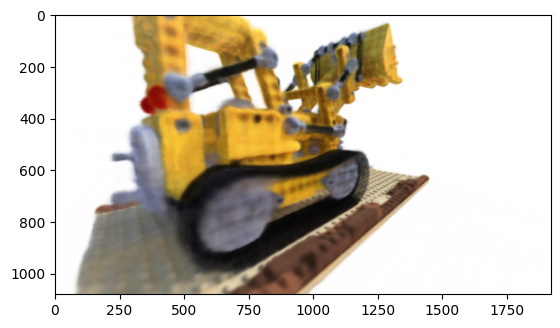

In [5]:
plt.imshow(cHat)
plt.show()

### Save the rendered image

In [6]:
Image.fromarray((cHat.numpy()*255).astype(np.uint8), "RGB").save("nerf2.png")

### Generate and Save an animation

In [25]:
pos = torch.tensor([0.0, 0.0, 0.0])
eye = torch.tensor([-0.5,  -0.7,  0.3])
up = torch.tensor([0.0, 0.0, -1.0])

frames = []
numFrame = 120
duration = int(np.round(2000/numFrame))
for i in tqdm(range(numFrame)):
	angleFraction = 2*np.pi/numFrame
	eye[0] = 1.5*np.cos(i*angleFraction)
	eye[1] = 1.5*np.sin(i*angleFraction)
	eye[2] = 0.3 - 0.2*np.cos(2*i*angleFraction)
	cHat = NerfModel.render(model, pos, eye, up, tn = 0, tf = 8, N = 192, imageWidth = 5*192, imageHeight = 5*108, chunkSize = 2048)
	frames.append(Image.fromarray((cHat.detach().numpy()*255).astype(np.uint8), "RGB"))
frames[0].save("nerf2.gif", save_all=True, append_images=frames[1:], duration=duration, loop=0)

100%|██████████| 120/120 [27:54<00:00, 13.95s/it]


In [100]:
x = torch.tensor([
	[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]],
	[[0.0, 0.0, 1.0], [1.0, 1.0, 1.0]]
])

# Tests

In [7]:
def sphere(o, d):
	c = torch.nn.functional.normalize(o, dim = 1)
	s = 10.0*(1.0 - torch.norm(o, dim = 1))
	return torch.abs(c), torch.nn.functional.sigmoid(s)

In [53]:
x = torch.tensor([
	[1.0, 0.0, 0.0],
	[2.0, -3.0, 7.0]
])
y = torch.tensor([7.87])
print(sphere(x, x))

(tensor([[1.0000, 0.0000, 0.0000],
        [0.2540, 0.3810, 0.8890]]), tensor([5.0000e-01, 1.4014e-30]))


In [26]:
x = np.array([0.2540, 0.3810, 0.8890])
print(np.linalg.norm(x))

0.9999989999995


In [156]:
device = 'cuda'

imageWidth = 10
imageHeight = 6
fov = 75

tangent = np.pi
tangent *= fov/360
tangent = np.tan(tangent)
ratio = imageWidth/imageHeight

px = tangent*torch.linspace(-ratio, ratio, imageWidth, device = device)
py = tangent*torch.linspace(-1.0, 1.0, imageHeight, device = device)
d = torch.zeros((imageWidth*imageHeight, 3), device = device)
		
for i in range(imageWidth):
	for j in range(imageHeight):
		k = i*imageHeight + j
		d[k, 0] = px[i]
		d[k, 1] = py[j]
		d[k, 2] = -1.0
		

print(torch.matmul(d, mat.to(device)))

tensor([[ 0.6402, -1.1684, -1.2039],
        [ 0.5149, -1.2937, -0.9533],
        [ 0.3896, -1.4190, -0.7027],
        [ 0.2643, -1.5443, -0.4520],
        [ 0.1390, -1.6696, -0.2014],
        [ 0.0137, -1.7949,  0.0492],
        [ 0.4393, -0.9674, -1.2039],
        [ 0.3140, -1.0927, -0.9533],
        [ 0.1886, -1.2180, -0.7027],
        [ 0.0633, -1.3433, -0.4520],
        [-0.0620, -1.4687, -0.2014],
        [-0.1873, -1.5940,  0.0492],
        [ 0.2383, -0.7665, -1.2039],
        [ 0.1130, -0.8918, -0.9533],
        [-0.0123, -1.0171, -0.7027],
        [-0.1376, -1.1424, -0.4520],
        [-0.2629, -1.2677, -0.2014],
        [-0.3882, -1.3930,  0.0492],
        [ 0.0373, -0.5655, -1.2039],
        [-0.0880, -0.6908, -0.9533],
        [-0.2133, -0.8161, -0.7027],
        [-0.3386, -0.9414, -0.4520],
        [-0.4639, -1.0667, -0.2014],
        [-0.5892, -1.1920,  0.0492],
        [-0.1636, -0.3646, -1.2039],
        [-0.2889, -0.4899, -0.9533],
        [-0.4142, -0.6152, -0.7027],
 

In [155]:
normalize = lambda x : torch.nn.functional.normalize(x, dim = 0)
cross = lambda x, y : torch.cross(x, y, dim = 0)
dot = lambda x, y : torch.dot(x, y).unsqueeze(0)
pos = torch.tensor(
	[0.0, 0.0, 0.0]
)
eye = torch.tensor(
	[1.0, 1.0, 1.0]
)
up = torch.tensor(
	[0.0, 0.0, 1.0]
)
#print(mat)
#print(torch.cat((x, dot(x, y))))

mat = NerfModel.render(None, pos, eye, up)
ray = torch.tensor([[1.0, 1.0, 1.0],[-1.0, 1.0, 1.0],[-1.0, -1.0, 1.0],[1.0, -1.0, 1.0]])

test = torch.tensor([
	[111, 112, 113],
	[121, 122, 123],
	[211, 212, 213],
	[221, 222, 223],
	[311, 312, 313],
	[321, 322, 323],
	[411, 412, 413],
	[421, 422, 423],
	[511, 512, 513],
	[521, 522, 523]
])

print(test.reshape(5, 2, 3)[2, 1, 0])
#print(torch.nn.functional.normalize(ray, dim = 1))
#print(torch.matmul(ray, mat))

tensor(321)


In [22]:
test = torch.from_numpy(np.load('training_data.pkl', allow_pickle = True))
testTensorDataset = TensorDataset(test[:,:3], test[:, 3:6], test[:, 6:])
testDataLoader = DataLoader(testTensorDataset, batch_size=1024, shuffle=True)
#test = np.load('testing_data.pkl', allow_pickle = True)

In [38]:
print(test[1368, :3])
print(test[1368, 3:6])
print(test[1368, 6:])
#for o, d, C in testDataLoader:
#	print("batch!")
#	print(o.shape)
#	print(d.shape)
#	print(C.shape)

tensor([-0.0538,  3.8455,  1.2081])
tensor([ 0.0682, -0.9970,  0.0363])
tensor([1., 1., 1.])


In [101]:
device = 'cuda'
model = NerfModel().to(device)
o = torch.tensor([
	[1.0, 0.0, 0.0],
	[0.0, 1.0, 0.0],
	[0.0, 0.0, -1.0],
	[1.0, 1.0, 0.0]
], device = device)
d = -o
print(NerfModel.computeCHat(model, o, d))

tensor([[33.5685, 31.6424, 32.2837],
        [33.2734, 32.3446, 33.1299],
        [33.6086, 32.1018, 32.1020],
        [33.5069, 32.3866, 32.8126]], device='cuda:0', grad_fn=<SumBackward1>)


In [5]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print(x[3:6])

[3, 4, 5]


In [88]:
tn = 0.0
tf = 1.0
n = 8

deltaT = (tf - tn)/n
print(torch.linspace(tn, tf - deltaT, n))
r = torch.rand((3, n))
print(r)
t = torch.linspace(tn, tf - deltaT, n).expand(3, n) + deltaT*r
print(t)

ones = torch.ones((3, 1))
print(torch.ones((3, 1)))
delta = torch.cat((
	t[:, 1:] - t[:, :-1],
	ones
), 1)
print(delta)
exp = torch.exp(-delta)
print(exp)
T = torch.cumprod(exp, 1)
T = torch.cat((ones, T[:, :-1]), dim = 1)
print(T)
print(T*(1 - exp))

tensor([0.0000, 0.1250, 0.2500, 0.3750, 0.5000, 0.6250, 0.7500, 0.8750])
tensor([[0.6301, 0.7187, 0.2320, 0.3923, 0.9979, 0.8144, 0.0162, 0.8890],
        [0.3081, 0.6026, 0.4295, 0.1013, 0.1270, 0.7545, 0.4516, 0.3995],
        [0.6794, 0.8031, 0.4350, 0.8322, 0.2535, 0.0243, 0.4581, 0.9588]])
tensor([[0.0788, 0.2148, 0.2790, 0.4240, 0.6247, 0.7268, 0.7520, 0.9861],
        [0.0385, 0.2003, 0.3037, 0.3877, 0.5159, 0.7193, 0.8064, 0.9249],
        [0.0849, 0.2254, 0.3044, 0.4790, 0.5317, 0.6280, 0.8073, 0.9948]])
tensor([[1.],
        [1.],
        [1.]])
tensor([[0.1361, 0.0642, 0.1450, 0.2007, 0.1021, 0.0252, 0.2341, 1.0000],
        [0.1618, 0.1034, 0.0840, 0.1282, 0.2034, 0.0871, 0.1185, 1.0000],
        [0.1405, 0.0790, 0.1747, 0.0527, 0.0963, 0.1792, 0.1876, 1.0000]])
tensor([[0.8728, 0.9379, 0.8650, 0.8182, 0.9030, 0.9751, 0.7913, 0.3679],
        [0.8506, 0.9018, 0.9194, 0.8797, 0.8159, 0.9166, 0.8883, 0.3679],
        [0.8690, 0.9241, 0.8397, 0.9487, 0.9081, 0.8359, 0.8290, 0.

In [89]:
x = torch.tensor([
	[11.0, 12.0, 13.0],
	[21.0, 22.0, 23.0]
])
#print(x.shape)
print(x.unsqueeze(1).shape)
y = torch.tensor([
	[1.0, 2.0, 3.0, 4.0, 5.0],
	[0.1, 0.2, 0.3, 0.4, 0.5]
])
#print(y.shape)
#print(x + y)
print(y.unsqueeze(2).shape)
z = torch.tensor([
	[1.0, 0.5, 0.2],
	[0.2, 0.5, 1.0]
])
print(z.unsqueeze(1).shape)

print(x*z)
#w = x.unsqueeze(1) + y.unsqueeze(2)*z.unsqueeze(1)
#q = w.reshape(-1, 3)
#print(w.shape)
#print(w)
#print(w.reshape(-1, 3))
#print(q.reshape(w.shape))
#print(w.shape[:-1])
#print(x.unsqueeze(1).expand(x.shape[0], 5, x.shape[1]))
#print(x.expand(5, x.shape[0], x.shape[1]).transpose(0, 1) )
#print(x.unsqueeze(1) + torch.einsum('ij,ik->ijk', y, z))

torch.Size([2, 1, 3])
torch.Size([2, 5, 1])
torch.Size([2, 1, 3])
tensor([[11.0000,  6.0000,  2.6000],
        [ 4.2000, 11.0000, 23.0000]])
